# Certis Quickstart

In [1]:
import certis
from typing import *

# Supported Order Types
- LIMIT
- MARKET
- STOP_MARKET
- STOP_LOSS_MARKET
- TAKE_PROFIT_MARKET

<a href="https://www.investor.gov/introduction-investing/investing-basics/how-stock-markets-work/types-orders"> order type docs for beginners

In [2]:
certis.OrderType.ORDERS

['MARKET', 'LIMIT', 'STOP_MARKET', 'STOP_LOSS_MARKET', 'TAKE_PROFIT_MARKET']

# Supportd Order Sides
LONG: betting for upside  
SHORT: betting for downside

In [3]:
print("certis.OrderSide.LONG:", certis.OrderSide.LONG)
print("certis.OrderSide.SHORT:", certis.OrderSide.SHORT)

certis.OrderSide.LONG: 1
certis.OrderSide.SHORT: -1


In [4]:
from pprint import pprint

In [5]:
pprint({"margin": 10000, "portfolio_value": 10000.0, "position": {"size": 0, "side": 0, "avg_price": 0, "unrealized_pnl": 0.0}, "has_position": "False", "timestamp": 1579076100000000000}, indent=False)

{'has_position': 'False',
'margin': 10000,
'portfolio_value': 10000.0,
'position': {'avg_price': 0, 'side': 0, 'size': 0, 'unrealized_pnl': 0.0},
'timestamp': 1579076100000000000}


# Writing Trading Strategy With Certis
- function certis.Startegy.execute() -> executes order with given data and account info
- function certis.Strategy.calculate() -> calculates indicators, etc with given raw data

# MA Cross Strategy
- In this Tutorial, We will write a simple strategy called "MA Cross Strategy"
- BUY WHEN CLOSE > MA(CLOSE, 5)
- SELL WHEN CLOSE < MA(CLOSE, 5)

In [6]:
class MyFirstStrategy(certis.Strategy):
    def __init__(self, config):
        # config: Dict[str, Any]: config for this strategy
        # name: str: name for this strategy
        super().__init__(config, "MyFirstStrategy")
        self.ma_period = config["MA_PERIOD"]
        
    def calculate(self, data):
        # data: pd.DataFrame contains [open, high, low, close, volume, timestamp]
        # calculations here
        data["MA"] = data["close"].rolling(self.ma_period).mean()
        return data
    
    def execute(self, state_dict) -> List[certis.core.Action]:
        actions = []
        
        """
        state_dict example:
            {
                'has_position': 0,
                 'margin': 10000,
                 'portfolio_value': 10000.0,
                 'position': {
                     'avg_price': 0, 
                     'side': 0, 
                     'size': 0, 
                     'unrealized_pnl': 0.0
                 },
                 'timestamp': 1579076100000000000
            }
        """
        
        has_position = state_dict["account_info"]["has_position"]
        portfolio_value = state_dict["account_info"]["portfolio_value"]
        position_size = state_dict["account_info"]["position"]["size"]
        data = state_dict["data"]
                
        if not state_dict["account_info"]["has_position"]:
            if data["close"] > data["MA"]: # if above ma
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=portfolio_value / data["close"], # full bet!,
                    order_side=certis.OrderSide.LONG,
                    order_price=None, # MARKET ORDER
                    reduce_only=False
                )
                actions.append(order)
        
        else:
            if data["close"] < data["MA"]:
                order = certis.Order(
                    order_type=certis.OrderType.MARKET,
                    order_quantity=position_size, # full bet!,
                    order_side=certis.OrderSide.SHORT,
                    order_price=None, # MARKET ORDER
                    reduce_only=True
                )
                actions.append(order)
                
        return actions
    

# Market Info Object
- essential market info for the backtesting
- maker fee: fee for limit orders
- taker fee: fee for market orders
- slippage: slippage applied for market orders
- tick_size: tick size
- minimum_order_size: minimum order size

In [7]:
market_info = certis.MarketInfo(
    maker_fee=0.001,
    taker_fee=0.001,
    slippage=0.001,
    minimum_order_size=0.001,
    tick_size=0.01
)

# Load data
Certis Supports pandas DataFrame with [timestamp, open, high, low, close, volume] with datetime indexes

In [8]:
from yfinance import Ticker

data = Ticker("BTC-USD").history(period="max")
data = data[data.columns[:5]]
data.columns = ["open", "high", "low", "close", "volume"]
data["timestamp"] = data.index.astype(int)

# Initialize Engine
### to initialize certis backtesting engine, you need following components:
- data: pandas DataFrame
- initial margin: float
- market info: MarketInfo Object
- strategy: Strategy Class
- strategy config: strategy config

In [9]:
initial_margin = 100000
strategy_config = {"MA_PERIOD": 28}

engine = certis.Engine(
    data,
    initial_margin,
    market_info,
    MyFirstStrategy,
    strategy_config
)

In [10]:
engine.run()

100%|██████████| 2574/2574 [00:00<00:00, 100949.44it/s]


# Analyzing Results
- engine.logger.account_infos: account info for timestamp-by-timestamp
- engine.logger.transactions: order fill (transactions)
- engine.logger.unfilled_order: unfilled order for timestamp-by-timestamp

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
account_info_df = pd.DataFrame(engine.logger.account_infos)
account_info_df.index = pd.to_datetime(account_info_df["timestamp"])

In [13]:
account_info_df

,margin,portfolio_value,position,has_position,timestamp
timestamp,,,,,
2014-10-15,1.000000e+05,1.000000e+05,"{'size': 0, 'side': 0, 'avg_price': 0, 'unreal...",0,1.413331e+18
2014-10-16,9.989988e+04,9.825920e+04,"{'size': 249.457, 'side': 1.0, 'avg_price': 40...",1,1.413418e+18
2014-10-17,9.989988e+04,9.521159e+04,"{'size': 249.457, 'side': 1.0, 'avg_price': 40...",1,1.413504e+18
2014-10-18,9.989988e+04,9.551143e+04,"{'size': 249.457, 'side': 1.0, 'avg_price': 40...",1,1.413590e+18
2014-10-19,9.989988e+04,9.742826e+04,"{'size': 249.457, 'side': 1.0, 'avg_price': 40...",1,1.413677e+18
...,...,...,...,...,...
2021-10-31,9.121182e+06,1.172140e+07,"{'size': 189.752, 'side': 1.0, 'avg_price': 48...",1,1.635638e+18
2021-11-01,9.121182e+06,1.161326e+07,"{'size': 189.752, 'side': 1.0, 'avg_price': 48...",1,1.635725e+18
2021-11-02,9.121182e+06,1.155358e+07,"{'size': 189.752, 'side': 1.0, 'avg_price': 48...",1,1.635811e+18


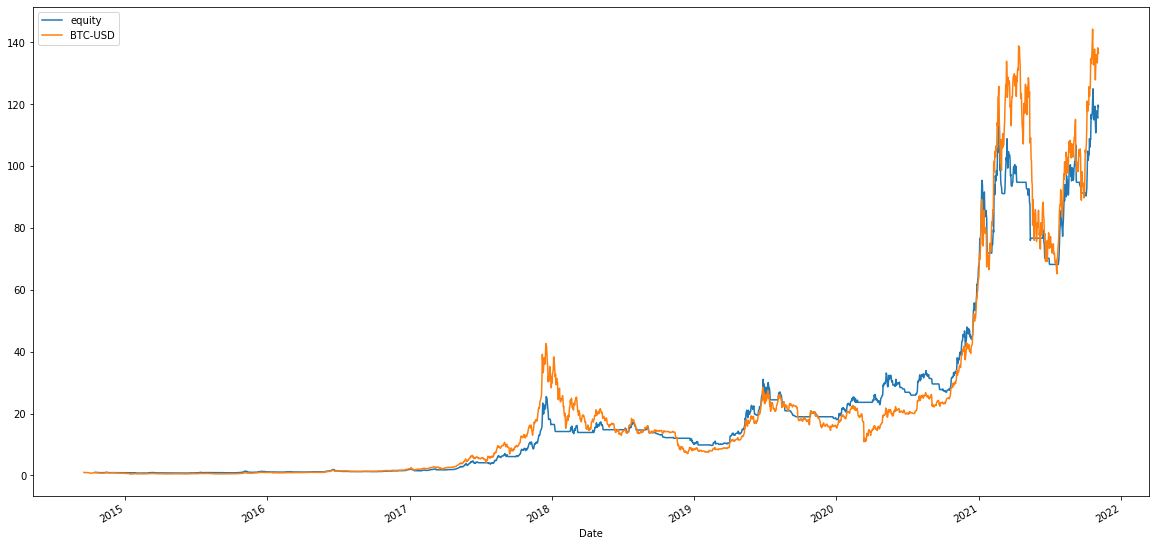

In [14]:
(account_info_df["portfolio_value"] / initial_margin).plot(label="equity", figsize=(20, 10))
(data["close"] / data["close"][0]).plot(label="BTC-USD")
plt.legend()